# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [181]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor


# from scipy.stats import ks_2samp
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy


In [52]:
df = pd.read_csv('previsao_de_renda.csv')


In [53]:
df = df.fillna(0)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          15000 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [55]:
# 1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
df_train, df_test = train_test_split(df, test_size=0.25, random_state=13)

In [56]:
# 2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

r2s_train = []
r2s_test = []

for alpha in alphas:
    modelo = '''np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel + C(qtd_filhos, Treatment(0)) + C(educacao, Treatment("Secundário")) + C(estado_civil, Treatment("Casado"))
              + C(tipo_residencia, Treatment("Casa")) + tempo_emprego + qtd_filhos + idade + qt_pessoas_residencia'''
    md = smf.ols(modelo, data = df_train)
    reg = md.fit_regularized(method = 'elastic_net' 
                             , refit = True
                             , L1_wt = 0.001
                             , alpha = alpha)
    predictions = reg.predict(df_test)
    r2_test = r2_score(np.log(df_test['renda']), (predictions))
    r2s_test.append(r2_test)
    predictions_train = reg.predict(df_train)
    r2_train = r2_score(np.log(df_train['renda']), (predictions_train))
    r2s_train.append(r2_train)

print(f'Os R2 do train são {r2s_train}')
print(f'Os R2 do teste são {r2s_test}')
    

Os R2 do train são [0.34150373298764636, 0.34150373298764636, 0.3409592423332033, 0.34143366682518406, 0.34112621321153547, 0.34029926350810635]
Os R2 do teste são [0.33263343058416817, 0.3326334305841685, 0.33316156795801377, 0.33250523601874393, 0.33244599253169105, 0.33337150811327587]


Todos modelos tiveram praticamente o mesmo resultado para o R2

In [57]:
# 3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

r2s_train = []
r2s_test = []

for alpha in alphas:
    modelo = '''np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel + C(qtd_filhos, Treatment(0)) + C(educacao, Treatment("Secundário")) + C(estado_civil, Treatment("Casado"))
              + C(tipo_residencia, Treatment("Casa")) + tempo_emprego + qtd_filhos + idade + qt_pessoas_residencia'''
    md = smf.ols(modelo, data = df_train)
    reg = md.fit_regularized(method = 'elastic_net' 
                             , refit = True
                             , L1_wt = 1
                             , alpha = alpha)
    predictions = reg.predict(df_test)
    r2_test = r2_score(np.log(df_test['renda']), (predictions))
    r2s_test.append(r2_test)
    predictions_train = reg.predict(df_train)
    r2_train = r2_score(np.log(df_train['renda']), (predictions_train))
    r2s_train.append(r2_train)

print(f'Os R2 do train são {r2s_train}')
print(f'Os R2 do teste são {r2s_test}')


Os R2 do train são [0.34150373298764636, 0.33983279335248795, 0.3346802537333996, 0.3317755123181636, 0.3317755123181636, 0.3317755123181636]
Os R2 do teste são [0.33263343058416817, 0.33321955670883097, 0.3264139651321738, 0.32546114934562387, 0.32546114934562387, 0.32546114934562387]


Neste também vemos que todos modelos ficaram parecidos, porém, vemos que o primeiro foi o que ficou mais assertivo tanto na base de teste como de treino

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11250 entries, 1143 to 338
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             11250 non-null  int64  
 1   data_ref               11250 non-null  object 
 2   id_cliente             11250 non-null  int64  
 3   sexo                   11250 non-null  object 
 4   posse_de_veiculo       11250 non-null  bool   
 5   posse_de_imovel        11250 non-null  bool   
 6   qtd_filhos             11250 non-null  int64  
 7   tipo_renda             11250 non-null  object 
 8   educacao               11250 non-null  object 
 9   estado_civil           11250 non-null  object 
 10  tipo_residencia        11250 non-null  object 
 11  idade                  11250 non-null  int64  
 12  tempo_emprego          11250 non-null  float64
 13  qt_pessoas_residencia  11250 non-null  float64
 14  renda                  11250 non-null  float64
dtypes: boo

In [59]:
# 4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?

import pandas as pd
import statsmodels.api as sm
import numpy as np

# Carregando a base de dados
data = df_train

# Convertendo variáveis categóricas em variáveis dummy
X = pd.get_dummies(data.drop(columns=['renda', 'Unnamed: 0', 'data_ref', 'id_cliente']), drop_first=True)
y = np.log(data['renda'])

# Garantindo que todas as colunas de X sejam do tipo float
X = X.astype(float)

# Garantindo que y seja do tipo float
y = y.astype(float)

# Função de seleção stepwise
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out=0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        # começamos pela lista de variaveis excluidas
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=np.float64)
        # para que toda variavel excluida vá sendo incluida e o p-value armazenado
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        # vai retirando as váriaveis menos significantes
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Executando a seleção stepwise
variaveis = stepwise_selection(X, y)

print('resulting features:')
print(variaveis)

Add  tempo_emprego                  with p-value 0.0
Add  sexo_M                         with p-value 0.0
Add  tipo_renda_Pensionista         with p-value 5.40021e-57
Add  tipo_renda_Empresário          with p-value 1.22717e-18
Add  educacao_Superior completo     with p-value 3.12309e-15
Add  posse_de_imovel                with p-value 1.67634e-13
Add  idade                          with p-value 5.15233e-09
Add  posse_de_veiculo               with p-value 0.0143931
Add  tipo_renda_Servidor público    with p-value 0.0398699
resulting features:
['tempo_emprego', 'sexo_M', 'tipo_renda_Pensionista', 'tipo_renda_Empresário', 'educacao_Superior completo', 'posse_de_imovel', 'idade', 'posse_de_veiculo', 'tipo_renda_Servidor público']


In [60]:
# Aplicando o melhor modelo sugerido pelo stepwise

modelo = '''np.log(renda) ~ sexo + tipo_renda + C(educacao, Treatment("Superior completo")) + idade + posse_de_veiculo + tempo_emprego'''
reg = smf.ols(modelo, data = df_train).fit()
reg.summary()
predictions_train = reg.predict(df_train)
r2_train = r2_score(np.log(df_train['renda']), (predictions_train))
predictions_test = reg.predict(df_test)
r2_test = r2_score(np.log(df_test['renda']), (predictions_test))

print(f'Os R2 do train são {r2_train} e do test {r2_test}')

Os R2 do train são 0.34571666880807583 e do test 0.34179270637447523


Respodendo a questão 5, o melhor modelo de todos ficou o stepwise, ele conseguiu de uma forma que o R2 ficou um pouco melhor do que nos outros tipos de ajuste do modelo.

In [177]:
# 6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

modelo = '''np.log(renda) ~ sexo + tipo_renda + C(educacao, Treatment("Superior completo")) + sexo:tempo_emprego + tempo_emprego * np.log(idade) + sexo:idade + I((tempo_emprego + 1) ** -1)'''
reg = smf.ols(modelo, data = df_train).fit()
reg.summary()
df_train['predictions'] = reg.predict(df_train)
df_train['predictions'] = (df_train['predictions'])
df_train['res_log'] = reg.resid
r2_train = r2_score(np.log(df_train['renda']), df_train['predictions'])
predictions_test = reg.predict(df_test)
r2_test = r2_score(np.log(df_test['renda']), (predictions_test))

print(f'Os R2 do train são {r2_train} e do test {r2_test}')

Os R2 do train são 0.3644283672931128 e do test 0.3601269357006034


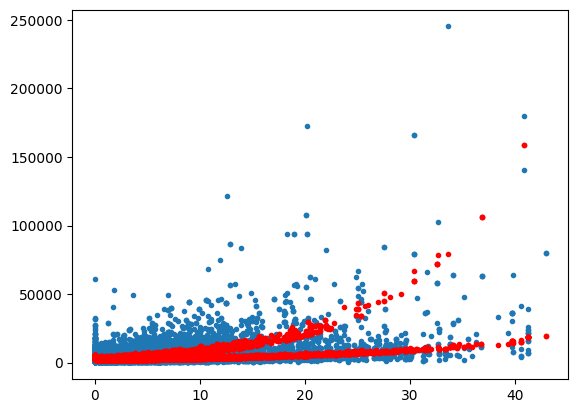

In [178]:
plt.plot(df_train['tempo_emprego'], df_train['renda'], '.')
plt.plot(df_train['tempo_emprego'], np.exp(df_train['predictions']), 'r.')

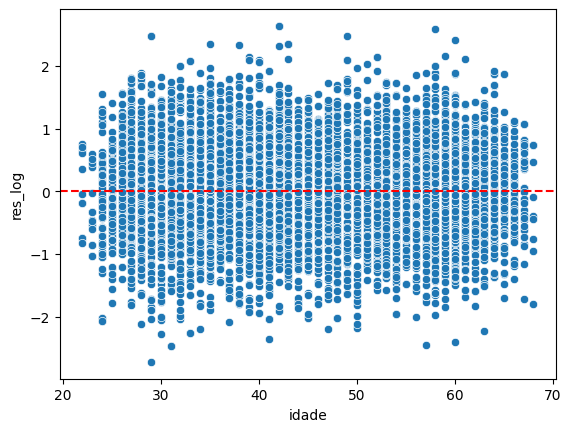

In [179]:
sns.scatterplot(x = 'idade', y = 'res_log', data = df_train)
plt.axhline(y=0, color='r', linestyle='--')

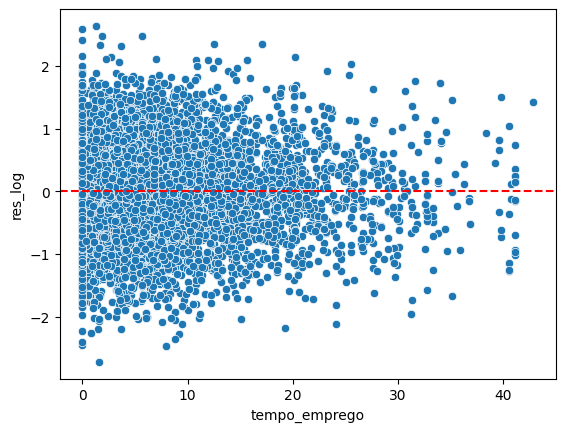

In [180]:
sns.scatterplot(x = 'tempo_emprego', y = 'res_log', data = df_train)
plt.axhline(y=0, color='r', linestyle='--')

 Consegui um R2 na base de testes de 0.3601 melhor que o anterior, talvez, possa ser um overfitting. Porém o modelo está mais treinado e ajustado agora.

In [186]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=13)

In [187]:
X_train = pd.get_dummies(df_train.drop(columns=['renda', 'data_ref']), drop_first=True)
y_train = np.log(df_train['renda'])
X_test = pd.get_dummies(df_test.drop(columns=['renda', 'data_ref']), drop_first=True)
y_test = np.log(df_test['renda'])

In [190]:
rf = RandomForestRegressor(random_state=13)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=13)

In [191]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [192]:
r2_train_rf = r2_score(y_train, y_train_pred)
r2_test_rf = r2_score(y_test, y_test_pred)

In [193]:
print(f'R² na base de treino: {r2_train_rf}')
print(f'R² na base de teste: {r2_test_rf}')

R² na base de treino: 0.9228423345843636
R² na base de teste: 0.4384540038457182


Conseguimos um R2 melhor com facilidade usando o modelo de árvore de regressão do Scikit Learn